In [1]:
import os
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast
from pathlib import Path
from PIL import Image
from torchvision import transforms, models

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

print('Torch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Torch version: 2.7.0+cpu
Device: cpu


In [2]:
root_dir = './data_spectrograms/'
image_dir = './data_spectrograms/'
image_paths = []

for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(root, file))

print(f"Found {len(image_paths)} images.")

Found 917 images.


In [3]:
def set_seed(seed=30):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def cleanup_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

In [4]:
class CustomSpectrogramDataset(Dataset):
    def __init__(self, root_dir, annotation_file=None, transform=None, image_size=(224, 224)):
        self.root_dir = Path(root_dir)
        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

        self.samples = []

        if annotation_file:
            # Read file list and resolve each path
            with open(annotation_file, 'r') as f:
                listed_files = [ln.strip() for ln in f if ln.strip()]

            for rel_path in listed_files:
                rel_path = rel_path.replace("\\", "/")  # normalize for Windows
                cls_name = rel_path.split('/')[0]       # first part = class folder
                if cls_name not in self.class_to_idx:
                    print(f"Skipping {rel_path} (unknown class '{cls_name}')")
                    continue

                full_path = self.root_dir / rel_path
                if full_path.exists():
                    self.samples.append((str(full_path), self.class_to_idx[cls_name]))
                else:
                    print(f"Missing file: {full_path}")
        else:
            # No annotation file → just take all PNGs
            for cls in self.classes:
                for full in (self.root_dir / cls).glob("*.png"):
                    self.samples.append((str(full), self.class_to_idx[cls]))

        if len(self.samples) == 0:
            raise ValueError(f"No spectrogram samples found in {root_dir} with given annotation file.")

        self.transform = transform or transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)


In [5]:
# train_transforms = transforms.Compose([
#     transforms.RandomResizedCrop(112, scale=(0.8, 1.0)),  # Random crop (time/freq region)
#     transforms.RandomApply([
#         transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1)
#     ], p=0.5),
#     transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Small shift in time/freq
#     transforms.ToTensor(),
#     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
# ])

train_transforms = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Validation transforms (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [6]:
DATA_ROOT = './data_spectrograms/'
TRAIN_LIST = './data_splits/train.txt'
VAL_LIST   = './data_splits/val.txt'
TEST_LIST  = './data_splits/test.txt'

In [7]:
# Load datasets once
train_ds = CustomSpectrogramDataset(DATA_ROOT, TRAIN_LIST, transform=train_transforms)
val_ds = CustomSpectrogramDataset(DATA_ROOT, VAL_LIST, transform=val_transforms)
test_ds = CustomSpectrogramDataset(DATA_ROOT, TEST_LIST, transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

Class label: 2 (COPD)


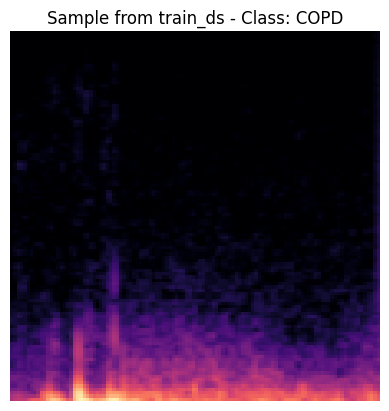

In [8]:
def imshow(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))
    img = img * 0.5 + 0.5  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

# Pick a random sample
sample_idx = random.randint(0, len(train_ds) - 1)
image, label = train_ds[sample_idx]

# Get class name (if available)
class_name = [k for k, v in train_ds.class_to_idx.items() if v == label.item()][0]

print(f"Class label: {label.item()} ({class_name})")
imshow(image)
plt.title(f"Sample from train_ds - Class: {class_name}")
plt.show()

In [9]:
def print_model_parameters(model, model_name="Model"):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\n--- {model_name} Parameters ---")
    print(f"Total Parameters:     {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")

In [10]:
# model factory functions
def get_teacher(num_classes=6, pretrained=True):
    try:
        if pretrained:
            teacher = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        else:
            teacher = models.resnet50(weights=None)
    except Exception as e:
        print('Warning: could not load ResNet50 pretrained weights:', e)
        teacher = models.resnet50(weights=None)
    teacher.fc = nn.Linear(teacher.fc.in_features, num_classes)
    return teacher

def get_student(num_classes=6, pretrained=True):
    try:
        if pretrained:
            student = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
        else:
            student = models.mobilenet_v2(weights=None)
    except Exception as e:
        print('Warning: could not load MobileNetV2 pretrained weights:', e)
        student = models.mobilenet_v2(weights=None)
    student.classifier[1] = nn.Linear(student.last_channel, num_classes)
    return student

In [11]:
# teacher finetuning
def finetune_teacher(teacher, train_loader, val_loader, device, epochs=15, lr=1e-4, save_path=None):
    """Memory-efficient teacher finetuning with reduced epochs"""
    teacher = teacher.to(device)
    teacher.train()
    optimizer = torch.optim.Adam(teacher.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    criterion = nn.CrossEntropyLoss()
    scaler = GradScaler()

    best_acc = 0.0
    best_state = None
    
    for epoch in range(epochs):
        teacher.train()
        running_loss = 0.0
        total = 0; correct = 0
        
        for batch_idx, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            
            with autocast():
                outs = teacher(imgs)
                loss = criterion(outs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            _, preds = torch.max(outs, 1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()
            
            # Memory cleanup every 20 batches
            if batch_idx % 20 == 0:
                del imgs, labels, outs
                cleanup_memory()

        avg_train_loss = running_loss / max(1, len(train_loader))
        train_acc = 100.*correct/total if total>0 else 0.0

        # Validation
        teacher.eval()
        val_loss = 0.0; total=0; correct=0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                
                with autocast():
                    outs = teacher(imgs)
                    loss = criterion(outs, labels)
                
                val_loss += loss.item()
                _, preds = torch.max(outs,1)
                total += labels.size(0)
                correct += preds.eq(labels).sum().item()
                
                del imgs, labels, outs
                
        avg_val_loss = val_loss / max(1, len(val_loader))
        val_acc = 100.*correct/total if total>0 else 0.0

        scheduler.step(avg_val_loss)
        if epoch % 10 == 0: 
            print(f'Epoch {epoch+1}/{epochs} - train_loss: {avg_train_loss:.4f} train_acc: {train_acc:.2f}% - val_loss: {avg_val_loss:.4f} val_acc: {val_acc:.2f}%')

        if val_acc > best_acc:
            best_acc = val_acc
            best_state = copy.deepcopy(teacher.state_dict())
            if save_path:
                torch.save(best_state, save_path)

        cleanup_memory()

    if best_state is not None:
        teacher.load_state_dict(best_state)
    teacher.eval()
    cleanup_memory()
    return teacher, best_acc

In [12]:
# knowledge distillation training
def train_student_kd(
    teacher, student, train_loader, val_loader, device,
    epochs=30, lr=1e-4, alpha=0.7, temperature=4.0,
    save_path='./student_best.pth'
):
    """Ultra memory-efficient knowledge distillation training"""
    # Move models to device
    teacher.to(device)
    student.to(device)
    teacher.eval()  # Keep teacher in eval mode
    
    # Freeze teacher completely to save memory
    for param in teacher.parameters():
        param.requires_grad = False
    
    optimizer = torch.optim.Adam(student.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    scaler = GradScaler()

    best_val_acc = 0.0
    history = {
        'train_ce_loss': [], 'train_mse_loss': [], 'train_total_loss': [],
        'val_ce_loss': [], 'val_mse_loss': [], 'val_total_loss': [],
        'val_acc': []
    }

    print(f"Training with temperature={temperature}, alpha={alpha} (KD weight)")
    print("Using ultra memory-efficient KD")

    for epoch in range(epochs):
        # ==== TRAIN ====
        student.train()
        ce_sum, mse_sum, total_sum = 0.0, 0.0, 0.0
        
        for batch_idx, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            # Get teacher outputs (no gradients needed)
            with torch.no_grad():
                teacher_outputs = teacher(imgs).detach()

            optimizer.zero_grad()

            with autocast():
                student_outputs = student(imgs)

                # Calculate losses
                ce_loss = F.cross_entropy(student_outputs, labels)
                
                # mse losses
                teacher_soft = F.softmax(teacher_outputs / temperature, dim=1)
                student_soft = F.softmax(student_outputs / temperature, dim=1)
                mse_loss = F.mse_loss(student_soft, teacher_soft) * (temperature ** 2)
                
                # Combined loss
                total_loss = alpha * mse_loss + (1 - alpha) * ce_loss

            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Track losses
            ce_sum += ce_loss.item()
            mse_sum += mse_loss.item()
            total_sum += total_loss.item()

            # Aggressive memory cleanup every 10 batches
            if batch_idx % 10 == 0:
                del imgs, labels, teacher_outputs, student_outputs, ce_loss, mse_loss, total_loss
                cleanup_memory()

        avg_train_ce = ce_sum / len(train_loader)
        avg_train_mse = mse_sum / len(train_loader)
        avg_train_total = total_sum / len(train_loader)

        # ==== VALIDATION ====
        student.eval()
        ce_sum, mse_sum, total_sum = 0.0, 0.0, 0.0
        total, correct = 0, 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                with autocast():
                    teacher_outputs = teacher(imgs)
                    student_outputs = student(imgs)

                    # Calculate losses
                    # Hard-label supervision
                    ce_loss = F.cross_entropy(student_outputs, labels)
                    
                    # Soft-label supervision (teacher guidance)
                    teacher_soft = F.softmax(teacher_outputs / temperature, dim=1)
                    student_soft = F.softmax(student_outputs / temperature, dim=1)
                    mse_loss = F.mse_loss(student_soft, teacher_soft) * (temperature ** 2)
                    
                    # Total loss (weighted)
                    total_loss = alpha * mse_loss + (1 - alpha) * ce_loss
                ce_sum += ce_loss.item()
                mse_sum += mse_loss.item()
                total_sum += total_loss.item()

                _, preds = torch.max(student_outputs, 1)
                total += labels.size(0)
                correct += preds.eq(labels).sum().item()

                del imgs, labels, teacher_outputs, student_outputs

        avg_val_ce = ce_sum / len(val_loader)
        avg_val_mse = mse_sum / len(val_loader)
        avg_val_total = total_sum / len(val_loader)
        val_acc = 100.0 * correct / total if total > 0 else 0.0

        scheduler.step(avg_val_total)

        # Store history
        history['train_ce_loss'].append(avg_train_ce)
        history['train_mse_loss'].append(avg_train_mse)
        history['train_total_loss'].append(avg_train_total)
        history['val_ce_loss'].append(avg_val_ce)
        history['val_mse_loss'].append(avg_val_mse)
        history['val_total_loss'].append(avg_val_total)
        history['val_acc'].append(val_acc)

        if epoch % 1 == 0:  
            print(f"Epoch {epoch+1}/{epochs} "
                  f"- Train CE: {avg_train_ce:.4f} MSE: {avg_train_mse:.4f} Total: {avg_train_total:.4f} "
                  f"- Val CE: {avg_val_ce:.4f} MSE: {avg_val_mse:.4f} Total: {avg_val_total:.4f} "
                  f"- Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(student.state_dict(), save_path)

        cleanup_memory()

    cleanup_memory()
    return student, best_val_acc, history

In [13]:
def save_student_as_tflite(student, example_input, output_path="student_model.tflite"):
    """
    Export a trained PyTorch model to TensorFlow Lite (.tflite)
    without using ONNX or onnx-tf.
    """

    student.eval()

    traced_model = torch.jit.trace(student, example_input)
    torchscript_path = "student_model.pt"
    traced_model.save(torchscript_path)
    print(f"[INFO] TorchScript model saved to {torchscript_path}")

    class TorchModelWrapper(tf.Module):
        def __init__(self, torch_model):
            super().__init__()
            self.torch_model = torch_model

        @tf.function(input_signature=[tf.TensorSpec(shape=example_input.shape, dtype=tf.float32)])
        def __call__(self, x):
            x_torch = torch.from_numpy(x.numpy()).to(next(student.parameters()).device)
            with torch.no_grad():
                y_torch = self.torch_model(x_torch)
            return tf.convert_to_tensor(y_torch.cpu().numpy(), dtype=tf.float32)

    wrapper = TorchModelWrapper(student)

    converter = tf.lite.TFLiteConverter.from_concrete_functions([wrapper.__call__.get_concrete_function()])
    converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optional: enable quantization
    tflite_model = converter.convert()

    with open(output_path, "wb") as f:
        f.write(tflite_model)
    print(f"TFLite model exported to {output_path}")

In [14]:
def run_kd(save_tflite=True):
    NUM_CLASSES = 6
    seed = 3  # single run only

    results = {
        'test_acc': None,
        'val_acc': None,
        'train_ce_loss': None,
        'train_mse_loss': None,
        'train_total_loss': None,
        'val_ce_loss': None,
        'val_mse_loss': None,
        'val_total_loss': None,
        'classification_report': None,
        'teacher_acc': None,
        'confusion_matrix': None,
        'y_true': None,
        'y_pred': None
    }

    print("="*80)
    print("KNOWLEDGE DISTILLATION EXPERIMENT - SINGLE RUN")
    print(f"Dataset size: Train={len(train_ds)}, Val={len(val_ds)}, Test={len(test_ds)}")
    print(f"Classes: {train_ds.classes}")
    print("="*80)

    set_seed(seed)
    cleanup_memory()

    # --- Teacher & Student Initialization ---
    teacher = get_teacher(NUM_CLASSES, pretrained=True).to(device)
    student = get_student(NUM_CLASSES, pretrained=True).to(device)

    print_model_parameters(teacher, "Teacher (ResNet50)")
    print_model_parameters(student, "Student (MobileNetV2)")

    # --- Train Teacher ---
    print("Finetuning teacher...")
    teacher, teacher_acc = finetune_teacher(
        teacher, train_loader, val_loader, device, 
        epochs=100, lr=1e-4, save_path=f'./teacher_seed{seed}.pth'
    )
    print(f"Teacher validation accuracy: {teacher_acc:.2f}%")
    results['teacher_acc'] = teacher_acc

    # --- Train Student with KD ---
    print("Starting knowledge distillation...")
    cleanup_memory()
    student, best_val_acc, history = train_student_kd(
        teacher, student, train_loader, val_loader, device,
        epochs=100,
        lr=1e-4, 
        alpha=0.7,
        temperature=4.0,
        save_path=f'./student_seed{seed}.pth'
    )

    results['val_acc'] = history['val_acc']
    results['train_ce_loss'] = history['train_ce_loss']
    results['train_mse_loss'] = history['train_mse_loss']
    results['train_total_loss'] = history['train_total_loss']
    results['val_ce_loss'] = history['val_ce_loss']
    results['val_mse_loss'] = history['val_mse_loss']
    results['val_total_loss'] = history['val_total_loss']

    # --- Test Evaluation ---
    print("Evaluating on test set...")
    student.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outs = student(imgs)
            _, preds = torch.max(outs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            del imgs, labels, outs

    test_acc = 100.0 * np.mean(np.array(y_true) == np.array(y_pred))
    print(f"Test accuracy: {test_acc:.2f}%")
    results['test_acc'] = test_acc
    results['y_true'] = y_true
    results['y_pred'] = y_pred

    # --- Reports ---
    report = classification_report(y_true, y_pred, target_names=train_ds.classes, output_dict=True, zero_division=0)
    results['classification_report'] = report
    cm = confusion_matrix(y_true, y_pred)
    results['confusion_matrix'] = cm

    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.classes)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix - Test Set (Acc: {test_acc:.2f}%)')
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(results['val_acc'], color='blue', label='Validation Accuracy')
    plt.title('Validation Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- TFLite Export (Batch-Compatible & Fixed) ---
    if save_tflite:
        print("Converting student model to TFLite (no ONNX)...")

        class TorchModelWrapper(tf.Module):
            def __init__(self, torch_model):
                super().__init__()
                self.torch_model = torch_model

            @tf.function(input_signature=[tf.TensorSpec([None, 3, 224, 224], tf.float32)])
            def __call__(self, x):
                def torch_forward(x_np):
                    x_torch = torch.from_numpy(x_np).to(device)
                    with torch.no_grad():
                        y_torch = self.torch_model(x_torch)
                    return y_torch.cpu().numpy()

                y = tf.py_function(func=torch_forward, inp=[x], Tout=tf.float32)
                y.set_shape([None, NUM_CLASSES])
                return y

        wrapper = TorchModelWrapper(student.eval())
        concrete_func = wrapper.__call__.get_concrete_function()

        converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        tflite_model = converter.convert()

        with open("student_model.tflite", "wb") as f:
            f.write(tflite_model)
        print("Student model saved as student_model.tflite (ONNX-free)")

    del teacher, student
    cleanup_memory()
    print("Run completed. Memory cleaned.")

    return results

KNOWLEDGE DISTILLATION EXPERIMENT - SINGLE RUN
Dataset size: Train=649, Val=134, Test=134
Classes: ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']

--- Teacher (ResNet50) Parameters ---
Total Parameters:     23,520,326
Trainable Parameters: 23,520,326

--- Student (MobileNetV2) Parameters ---
Total Parameters:     2,231,558
Trainable Parameters: 2,231,558
Finetuning teacher...


C:\Users\ALMIRA\AppData\Local\Temp\ipykernel_22816\331947480.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
c:\Users\ALMIRA\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
c:\Users\ALMIRA\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\ALMIRA\AppData\Local\Temp\ipykernel_22816\331947480.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\ALMIRA\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\autocast_mode.py:266:

Epoch 1/100 - train_loss: 0.9343 train_acc: 71.80% - val_loss: 0.4102 val_acc: 88.81%
Epoch 11/100 - train_loss: 0.0049 train_acc: 100.00% - val_loss: 0.2969 val_acc: 91.79%
Epoch 21/100 - train_loss: 0.0081 train_acc: 100.00% - val_loss: 0.3501 val_acc: 92.54%
Epoch 31/100 - train_loss: 0.0023 train_acc: 100.00% - val_loss: 0.2947 val_acc: 94.03%
Epoch 41/100 - train_loss: 0.0019 train_acc: 100.00% - val_loss: 0.2985 val_acc: 94.03%
Epoch 51/100 - train_loss: 0.0026 train_acc: 100.00% - val_loss: 0.2865 val_acc: 95.52%
Epoch 61/100 - train_loss: 0.0030 train_acc: 100.00% - val_loss: 0.2956 val_acc: 95.52%
Epoch 71/100 - train_loss: 0.0025 train_acc: 100.00% - val_loss: 0.2909 val_acc: 95.52%
Epoch 81/100 - train_loss: 0.0024 train_acc: 100.00% - val_loss: 0.2707 val_acc: 94.03%
Epoch 91/100 - train_loss: 0.0022 train_acc: 100.00% - val_loss: 0.2979 val_acc: 93.28%
Teacher validation accuracy: 95.52%
Starting knowledge distillation...
Training with temperature=4.0, alpha=0.7 (KD weight

C:\Users\ALMIRA\AppData\Local\Temp\ipykernel_22816\475899748.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\ALMIRA\AppData\Local\Temp\ipykernel_22816\475899748.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ALMIRA\AppData\Local\Temp\ipykernel_22816\475899748.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/100 - Train CE: 1.1740 MSE: 0.6135 Total: 0.7816 - Val CE: 0.7013 MSE: 0.3290 Total: 0.4407 - Val Acc: 89.55%
Epoch 2/100 - Train CE: 0.3647 MSE: 0.3802 Total: 0.3756 - Val CE: 0.3554 MSE: 0.1579 Total: 0.2171 - Val Acc: 91.04%
Epoch 3/100 - Train CE: 0.1796 MSE: 0.2475 Total: 0.2271 - Val CE: 0.3041 MSE: 0.0730 Total: 0.1423 - Val Acc: 91.79%
Epoch 4/100 - Train CE: 0.0839 MSE: 0.1655 Total: 0.1410 - Val CE: 0.2898 MSE: 0.0721 Total: 0.1374 - Val Acc: 90.30%
Epoch 5/100 - Train CE: 0.0397 MSE: 0.1073 Total: 0.0870 - Val CE: 0.2981 MSE: 0.0468 Total: 0.1222 - Val Acc: 91.79%
Epoch 6/100 - Train CE: 0.0113 MSE: 0.0597 Total: 0.0452 - Val CE: 0.2621 MSE: 0.0520 Total: 0.1150 - Val Acc: 91.04%
Epoch 7/100 - Train CE: 0.0107 MSE: 0.0377 Total: 0.0296 - Val CE: 0.2965 MSE: 0.0533 Total: 0.1263 - Val Acc: 90.30%
Epoch 8/100 - Train CE: 0.0051 MSE: 0.0322 Total: 0.0241 - Val CE: 0.2974 MSE: 0.0471 Total: 0.1222 - Val Acc: 91.79%
Epoch 9/100 - Train CE: 0.0035 MSE: 0.0207 Total: 0.0155

<Figure size 1000x800 with 0 Axes>

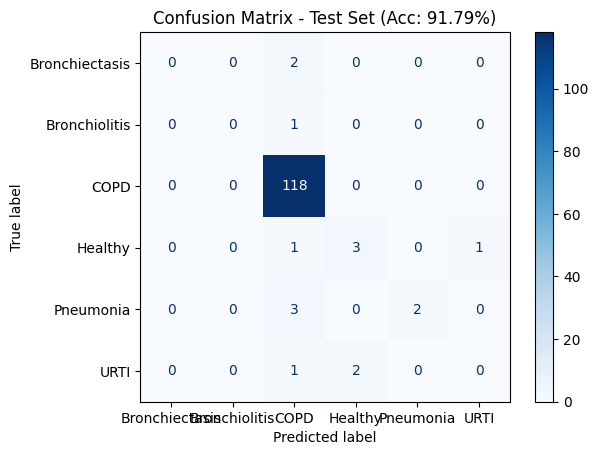

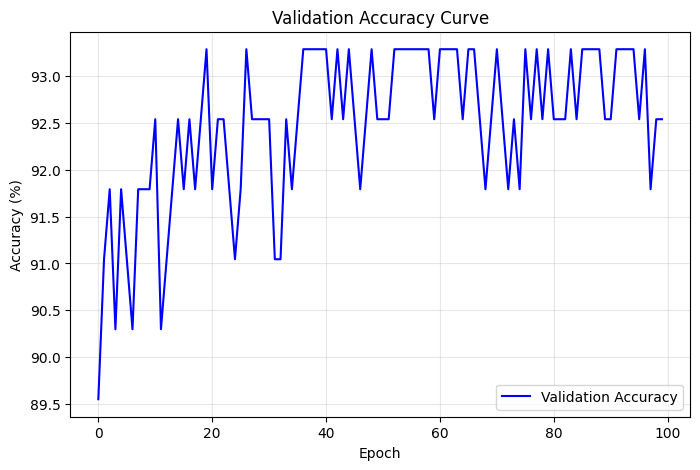

Converting student model to TFLite (no ONNX)...


ConverterError: Could not translate MLIR to FlatBuffer.c:\Users\ALMIRA\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compilation.py:178:1: error: 'tf.EagerPyFunc' op is neither a custom op nor a flex op
    concrete_function = _maybe_define_function(
^
c:\Users\ALMIRA\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compilation.py:283:1: note: called from
        concrete_function = _create_concrete_function(
^
c:\Users\ALMIRA\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compilation.py:310:1: note: called from
  traced_func_graph = func_graph_module.func_graph_from_py_func(
^
c:\Users\ALMIRA\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\framework\func_graph.py:1060:1: note: called from
    func_outputs = python_func(*func_args, **func_kwargs)
^
c:\Users\ALMIRA\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py:599:1: note: called from
          out = weak_wrapped_fn().__wrapped__(*args, **kwds)
^
c:\Users\ALMIRA\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py:1724:1: note: called from
    return wrapped_fn(*args, **kwargs)
^
c:\Users\ALMIRA\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\eager\polymorphic_function\autograph_util.py:41:1: note: called from
      return api.converted_call(
^
C:\Users\ALMIRA\AppData\Local\Temp\ipykernel_22816\3379885925.py:123:1: note: called from
c:\Users\ALMIRA\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\util\traceback_utils.py:150:1: note: called from
      return fn(*args, **kwargs)
^
c:\Users\ALMIRA\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\util\dispatch.py:1260:1: note: called from
        return dispatch_target(*args, **kwargs)
^
c:\Users\ALMIRA\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compilation.py:178:1: note: see current operation: %1 = "tf.EagerPyFunc"(%arg0) {Tin = [f32], Tout = [f32], device = "/job:localhost/replica:0/task:0/device:CPU:0", is_async = false, token = "pyfunc_0"} : (tensor<?x3x224x224xf32>) -> tensor<*xf32>
    concrete_function = _maybe_define_function(
^
c:\Users\ALMIRA\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\eager\polymorphic_function\tracing_compilation.py:178:1: note: Error code: ERROR_NEEDS_CUSTOM_OPS
<unknown>:0: error: failed while converting: 'main': 
Some ops in the model are custom ops, See instructions to implement custom ops: https://www.tensorflow.org/lite/guide/ops_custom 
Custom ops: EagerPyFunc
Details:
	tf.EagerPyFunc(tensor<?x3x224x224xf32>) -> (tensor<*xf32>) : {Tin = [f32], Tout = [f32], device = "/job:localhost/replica:0/task:0/device:CPU:0", is_async = false, token = "pyfunc_0"}

<unknown>:0: note: see current operation: 
"func.func"() <{function_type = (tensor<?x3x224x224xf32>) -> tensor<*xf32>, sym_name = "main"}> ({
^bb0(%arg0: tensor<?x3x224x224xf32>):
  %0 = "tfl.custom_tf"(%arg0) ({
  ^bb0(%arg1: tensor<?x3x224x224xf32>):
    %1 = "tf.EagerPyFunc"(%arg1) {Tin = [f32], Tout = [f32], device = "/job:localhost/replica:0/task:0/device:CPU:0", is_async = false, token = "pyfunc_0"} : (tensor<?x3x224x224xf32>) -> tensor<*xf32>
    "tfl.yield"(%1) : (tensor<*xf32>) -> ()
  }) {Tin = [f32], Tout = [f32], device = "/job:localhost/replica:0/task:0/device:CPU:0", is_async = false, token = "pyfunc_0"} : (tensor<?x3x224x224xf32>) -> tensor<*xf32>
  "func.return"(%0) : (tensor<*xf32>) -> ()
}) {tf.entry_function = {control_outputs = "", inputs = "x", outputs = "Identity"}} : () -> ()


In [15]:
if __name__ == "__main__":
    mp.set_start_method('spawn', force=True) 
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    results = run_kd(save_tflite=True)
    print("\nExperiment completed.")
    print(f"Final test accuracy: {results['test_acc']:.2f}%")
